# Use Pandas to Sort event arrivals csv files 
## according to max SNR value

##  Fei Zhang
### 2018-07-26

In [1]:
SOURCE_LATITUDE = 'source_latitude'
SOURCE_LONGITUDE = 'source_longitude'
STATION_LATITUDE = 'station_latitude'
STATION_LONGITUDE = 'station_longitude'
STATION_CODE = 'station_code'
FREQUENCY = 'no_of_summary_rays'

column_names = ['source_block', 'station_block',
                'residual', 'event_number',
                SOURCE_LONGITUDE, SOURCE_LATITUDE,
                'source_depth', STATION_LONGITUDE, STATION_LATITUDE,
                'observed_tt', 'locations2degrees', STATION_CODE, 'SNR', 'P_or_S']

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
!pwd


/g/data1a/ha3/fxz547/Githubz/passive-seismic/notebooks


In [4]:
# for S wave
inputcsv='/g/data1a/ha3/fxz547/travel_time_tomography/run5_events_1deg/outfile_S.csv'
residual_cutoff=10.0
sortedfile='sortedfile_S.csv'
sortedfile2= 'sortedfile2_S.csv'

# P wave
#inputcsv='/g/data/ha3/fxz547/Githubz/passive-seismic/seismic_events_arrivals_P_0.csv'
inputcsv='/g/data/ha3/fxz547/Githubz/passive-seismic/tempworks/outfile_P.csv'
residual_cutoff=5.0
sortedfile='sortedfile_P.csv'
sortedfile2= 'sortedfile2_P.csv'


In [5]:
import logging
import sys
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.DEBUG, stream=sys.stdout)

log =logging.getLogger()
log.info('Hello world!')

# def sort(output_file, sorted_file, residual_cutoff):
def sort2(output_file, sorted_file, residual_cutoff):
    """
    Sort and filter the arrivals.

    Sort based on the source and station block number.
    There are two stages of filtering:
    1. Filter based on the time residual
    2. Filter based on best Signal_to_Noise-Ratio seismic wave: If there are multiple source and station block combinations, we keep the
    row corresponding to the highest SNR value

    cmdline usage:
    cluster sort outfile_P.csv 5. -s sorted_P.csv
    cluster sort outfile_S.csv 10. -s sorted_S.csv


    :param output_file: output file from the gather stage (eg, outfile_P.csv)
    :param sorted_file: str, optional
        optional sorted output file path. Default: sorted.csv.
    :param residual_cutoff: float
        residual seconds above which arrivals are rejected.
    :return: pandas_df
    """

    print('Filtering arrivals.')

    cluster_data = pd.read_csv(output_file, header=None,
                               names=column_names)
    
    log.debug("Number of records in initial CSV file = %s", cluster_data.shape[0])
    
    cluster_data = cluster_data[abs(cluster_data['residual'])
                                < residual_cutoff]
    
    log.debug("Number of records after residual cutoff = %s", cluster_data.shape[0])
    
    cluster_data['source_depth'] = cluster_data['source_depth'] / 1000.0  # convert to KM?
    
    # groupby sorts by default
    # cluster_data.sort_values(by=['source_block', 'station_block'],
    #                          inplace=True)

    log.info('Sorting arrivals.')

    # groupby automatically sorts
#     med = cluster_data.groupby(
#         by=['source_block', 'station_block']
#         )['observed_tt'].quantile(q=.5, interpolation='lower').reset_index() # use a seq index:0,1,2,....

#  SNR value max
    med = cluster_data.groupby(
        by=['source_block', 'station_block']
        )['SNR'].max().reset_index() # use a seq index:0,1,2,.
    
    # med dataframe has three columns:  [source_block, station_block ,observed_tt]
    
    final_df = pd.merge(cluster_data, med, how='right',
                        on=['source_block', 'station_block', 'SNR'],
                        sort=True,
                        right_index=True)

    # Confirmed: drop_duplicates required due to possibly duplicated picks in
    #  the original engdahl events
    # refer: https://github.com/GeoscienceAustralia/passive-seismic/issues/51
    # The subset is specified as we have some stations that are very close?
    
    log.debug("Number of records before drop_duplicates = %s", final_df.shape[0])
    
    final_df.drop_duplicates(subset=['source_block', 'station_block'],
                             keep='first',  inplace=True)

    final_df.to_csv(sorted_file, header=False, index=False, sep=',')
    
    log.debug("Number of records in final pdf = %s", final_df.shape[0])
    return final_df


2018-08-07 11:30:47,973 | INFO : Hello world!


In [6]:
finalpdf = sort2(inputcsv,sortedfile,residual_cutoff)

Filtering arrivals.
2018-08-07 11:30:48,159 | DEBUG : Number of records in initial CSV file = 61721
2018-08-07 11:30:48,167 | DEBUG : Number of records after residual cutoff = 55208
2018-08-07 11:30:48,209 | INFO : Sorting arrivals.
2018-08-07 11:30:48,340 | DEBUG : Number of records before drop_duplicates = 24258
2018-08-07 11:30:48,896 | DEBUG : Number of records in final pdf = 23460


In [7]:
finalpdf.head()

,source_block,station_block,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,station_code,SNR,P_or_S
49650,130364,31202939,0.150000,5273000,100.7719,-0.1757,0.0,101.0400,0.3262,11.006560,0.569017,BKNI,49.615829,1
26347,130833,180555,3.750000,2755000,127.9925,-0.4697,0.0,138.5793,-35.0313,425.172023,35.945209,TWOA,13.547856,1
23276,131166,158938,-3.786733,2453000,121.1672,-0.6979,0.0,134.3660,-19.8777,304.204034,23.124791,WB5,12.414057,1
8850,131214,156024,-1.795504,904000,133.2542,-0.6908,0.0,125.6400,-18.0973,263.530413,18.945836,FITZ,332.555463,1
33158,132662,166565,1.050000,3478000,135.2243,-1.6387,0.0,151.0820,-25.3687,354.924562,28.227178,EIDS,9.582778,1


In [8]:
finalpdf.shape

(23460, 14)

In [9]:
#sort again
pdf2=sort2(sortedfile, sortedfile2, residual_cutoff )

Filtering arrivals.
2018-08-07 11:30:49,054 | DEBUG : Number of records in initial CSV file = 23460
2018-08-07 11:30:49,059 | DEBUG : Number of records after residual cutoff = 23460
2018-08-07 11:30:49,061 | INFO : Sorting arrivals.
2018-08-07 11:30:49,135 | DEBUG : Number of records before drop_duplicates = 23460
2018-08-07 11:30:49,585 | DEBUG : Number of records in final pdf = 23460


In [10]:
pdf2.head()

,source_block,station_block,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,station_code,SNR,P_or_S
0,130364,31202939,0.150000,5273000,100.7719,-0.1757,0.0,101.0400,0.3262,11.006560,0.569017,BKNI,49.615829,1
1,130833,180555,3.750000,2755000,127.9925,-0.4697,0.0,138.5793,-35.0313,425.172023,35.945209,TWOA,13.547856,1
2,131166,158938,-3.786733,2453000,121.1672,-0.6979,0.0,134.3660,-19.8777,304.204034,23.124791,WB5,12.414057,1
3,131214,156024,-1.795504,904000,133.2542,-0.6908,0.0,125.6400,-18.0973,263.530413,18.945836,FITZ,332.555463,1
4,132662,166565,1.050000,3478000,135.2243,-1.6387,0.0,151.0820,-25.3687,354.924562,28.227178,EIDS,9.582778,1


In [11]:
pdf2.shape

(23460, 14)

2018-08-07 11:30:49,720 | DEBUG : findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/g/data/ha3/fxz547/anaconda2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


<Figure size 432x288 with 0 Axes>

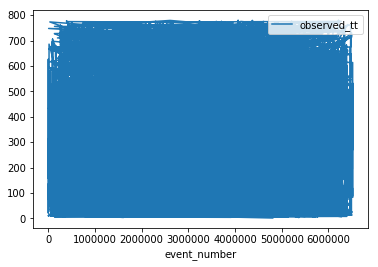

In [12]:
plt.figure(); pdf2.plot(x='event_number', y='observed_tt')
# plt.figure(); pdf2.plot(x='event_number', y='source_depth')
# plt.figure(); pdf2.plot(x='event_number', y='locations2degrees')
# plt.figure(); pdf2.plot(x='event_number', y='residual')  # less than +-10s



<Figure size 432x288 with 0 Axes>

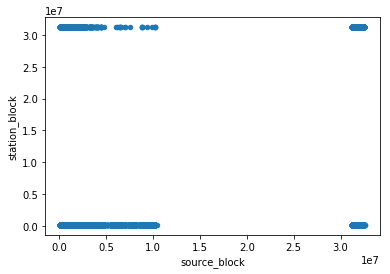

In [13]:
plt.figure(); pdf2.plot.scatter(x='source_block', y='station_block')

<Figure size 432x288 with 0 Axes>

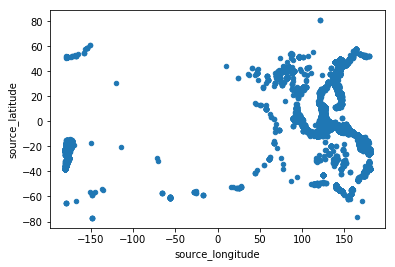

In [14]:
plt.figure(); pdf2.plot.scatter(x='source_longitude', y='source_latitude')

<Figure size 432x288 with 0 Axes>

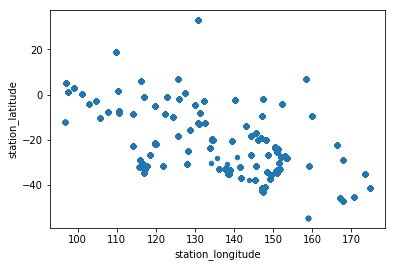

In [31]:
plt.figure(); pdf2.plot.scatter(x='station_longitude', y='station_latitude')

<Figure size 432x288 with 0 Axes>

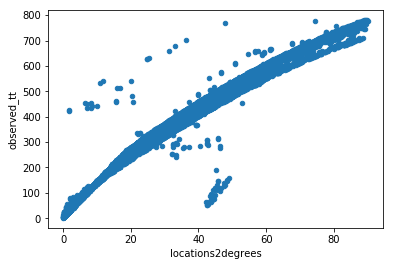

In [33]:
plt.figure(); pdf2.plot.scatter(x='locations2degrees', y='observed_tt')

<Figure size 432x288 with 0 Axes>

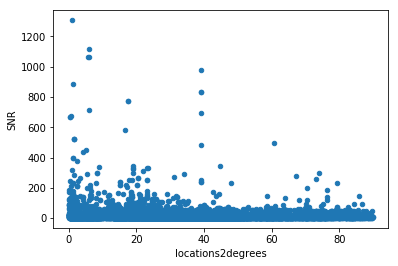

In [34]:
plt.figure(); pdf2.plot.scatter(x='locations2degrees', y='SNR')

In [16]:
 med = pdf2.groupby(by=['source_block', 'station_block'])[
        'observed_tt'].quantile(q=.5, interpolation='lower').reset_index()

In [17]:
med.head()

,source_block,station_block,observed_tt
0,130364,31202939,11.006560
1,130833,180555,425.172023
2,131166,158938,304.204034
3,131214,156024,263.530413
4,132662,166565,354.924562


In [18]:
med.shape

(23460, 3)

In [19]:
med2 = pdf2.groupby(
        by=['source_block', 'station_block'] )['SNR'].max().reset_index() # use a seq index:0,1,2,.

In [20]:
med2.head()

,source_block,station_block,SNR
0,130364,31202939,49.615829
1,130833,180555,13.547856
2,131166,158938,12.414057
3,131214,156024,332.555463
4,132662,166565,9.582778


In [21]:
med2.shape

(23460, 3)

In [22]:
pdf2.loc[2]

source_block          131166
station_block         158938
residual            -3.78673
event_number         2453000
source_longitude     121.167
source_latitude      -0.6979
source_depth               0
station_longitude    134.366
station_latitude    -19.8777
observed_tt          304.204
locations2degrees    23.1248
station_code             WB5
SNR                  12.4141
P_or_S                     1
Name: 2, dtype: object

In [23]:
pdf2.iloc[1]

source_block          130833
station_block         180555
residual                3.75
event_number         2755000
source_longitude     127.993
source_latitude      -0.4697
source_depth               0
station_longitude    138.579
station_latitude    -35.0313
observed_tt          425.172
locations2degrees    35.9452
station_code            TWOA
SNR                  13.5479
P_or_S                     1
Name: 1, dtype: object

In [24]:
pdf2.describe()

,source_block,station_block,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,SNR,P_or_S
count,2.346000e+04,2.346000e+04,23460.000000,2.346000e+04,23460.000000,23460.000000,23460.000000,23460.000000,23460.000000,23460.000000,23460.000000,23460.000000,23460.0
mean,1.532505e+07,2.278929e+06,0.024973,3.224787e+06,85.663270,-4.897048,0.143143,134.944512,-19.289314,364.564631,33.056320,12.763628,1.0
std,1.481460e+07,7.827617e+06,1.785204,1.913927e+06,118.436563,19.808115,0.171981,13.179486,11.497807,168.662924,19.248160,30.589980,0.0
min,1.303640e+05,1.315320e+05,-5.000000,3.000000e+03,-179.995400,-77.188300,0.000000,96.835000,-54.498200,1.299029,0.048722,1.501894,1.0
25%,9.927695e+05,1.560240e+05,-1.100000,1.507000e+06,105.349300,-17.631400,0.031079,128.296000,-26.582700,261.007631,19.435678,5.126403,1.0
50%,4.495808e+06,1.610400e+05,0.150000,3.235000e+06,129.168400,-6.218600,0.065356,134.367000,-19.959200,359.547859,30.944521,7.100788,1.0
75%,3.132478e+07,1.741280e+05,1.200000,4.895250e+06,151.455500,1.325500,0.167092,144.317000,-12.686200,477.021314,44.744537,11.565066,1.0
max,3.257619e+07,3.121566e+07,5.000000,6.519000e+06,179.997500,80.800000,0.668000,174.705000,32.809000,779.922265,89.988315,1307.319956,1.0


In [25]:
pdf2.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            23450, 23451, 23452, 23453, 23454, 23455, 23456, 23457, 23458,
            23459],
           dtype='int64', length=23460)

In [26]:
pdf2.index=pdf2.event_number

In [27]:
pdf2.index

Int64Index([5273000, 2755000, 2453000,  904000, 3478000, 5355000, 6334000,
            5071000, 5071000, 5071000,
            ...
            3112000, 3112000, 3112000, 3112000, 3112000, 6253000, 6179000,
            1526000,  897000,  897000],
           dtype='int64', name='event_number', length=23460)

In [28]:
pdf2.tail(n=5)

,source_block,station_block,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,station_code,SNR,P_or_S
event_number,,,,,,,,,,,,,,
6253000,32534715,164337,0.95,6253000,-179.0566,-20.3962,0.645,133.9710,-23.6471,429.172090,43.476542,AS06,6.018690,1
6179000,32534715,177671,4.05,6179000,-178.4087,-19.9659,0.635,137.5744,-33.0330,414.852401,41.167086,WHYH,8.608146,1
1526000,32535003,164337,1.25,1526000,-179.2445,-20.8474,0.645,133.9050,-23.6642,427.831637,43.261817,AS31,5.144998,1
897000,32576187,164337,1.10,897000,-179.0704,-19.6998,0.668,133.9700,-23.6652,429.152508,43.627759,AS07,7.415461,1
897000,32576187,168356,-1.30,897000,-179.0704,-19.6998,0.668,148.7580,-26.4853,318.822995,30.275572,RMQ,5.494720,1


In [29]:
pdf2.iloc[1]  # now .loc[2] does not work

source_block          130833
station_block         180555
residual                3.75
event_number         2755000
source_longitude     127.993
source_latitude      -0.4697
source_depth               0
station_longitude    138.579
station_latitude    -35.0313
observed_tt          425.172
locations2degrees    35.9452
station_code            TWOA
SNR                  13.5479
P_or_S                     1
Name: 2755000, dtype: object

In [30]:
#pdf2.loc[215]